# Model Peramalan ANN dan ARIMA
Penerapan model peramalan ANN dan ARIMA dalam meramalkan nilai dan volume ekspor impor dengan indikator AIS (sebagai var prediktor)

In [2]:
# LIBRARY
import pandas as pd                              #data manip
import numpy as np                               #array manip
import matplotlib.pyplot as plt                  #plot or graphic
#import scipy                                     #stats for boxcox transform
import warnings                                  #ignore warnings
import time                                      #timeee
import statsmodels.api as sm                     #model stat
import copy                                      #copyyy
import itertools                                 #iterasii
from statsmodels.tsa.arima.model import ARIMA    #model ARIMA
from datetime import datetime                    #datetime type manip
from sklearn.metrics import mean_squared_error   #mse n rmse
from sklearn.metrics import mean_absolute_error  #mae
from statsmodels.tsa.stattools import adfuller   #adfuller cek stationerity
from ipynb.fs.defs._2_ANN import *                #import from ANN urself
# Init transform scaling
#from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler #scaling with standard dev (standardize)
from sklearn.preprocessing import MinMaxScaler   #scaling with min and max  (normalize)
#scaler = MinMaxScaler()

# set digit behind comma, print only 4
%precision 4 
pd.set_option("display.precision", 4)
# ignore warning
warnings.filterwarnings(action='ignore')

# Func all

## Read data

In [3]:
def read_data(kolom, kolomx = 0, pertumbuhan = True, rename = False):
    '''
    Return dataframe untuk dimasukkan ke model peramalan dengan kolom terpilih sbg var X dan Y
    '''
    
    dataname = 'df_indikatorAIS.csv'
    # READ DATA
    dfori_ = pd.read_csv(dataname)#.dropna()
    cols = [c for c in dfori_.columns if c.lower()[-2:] == 'ct']
    dfori_ = dfori_[cols + ['EksporNilai', 'EksporVolume','ImporNilai','ImporVolume']]
    dfori_ = dfori_[kolom]

    dfori = dfori_.copy()
    dforix = pd.Series()
    if kolomx != 0:
        # Add X
        #[['cad_devisa(jutaUSD)','kurs_USD','bi_rate']]
        #kolomx = 2
        dforix = pd.read_csv('faktorAdd.csv').iloc[:,kolomx]
        dfori = pd.concat([dfori_,dforix], axis=1)
        dfori = dfori[[c for c in dfori if c not in dfori_.columns[-1]] + [dfori_.columns[-1]]]

    # Transform ke pertumbuhan
    # Var y ada di kolom berape
    #koly = 3
    koly = len(kolom)-1
    #
    if kolomx !=0 : koly+=1
    koly2 = koly; t=0

    # Transform
    df = dfori.copy()
    #df = (dfori/dfori.shift(1)*100-100) #transform ke bentuk pertumbuhan or
    df = df.diff()/df.shift(1) if pertumbuhan else df #pertumbuhan/return

    # Set index -> for (s)arima
    df['ds'] = pd.date_range(start='12/1/2018', end='12/1/2020', freq='MS')
    df = df.set_index('ds')
    #df.index = df.index.to_timestamp() #to_period()
    df.rename(columns={dfori.columns[koly]:'y'}, inplace=True)

    # Print easying
    print('---------------\n ANDA PAKE DATA ',dfori.columns[koly2].upper())
    _ = 'AIS+' if len(kolom)==6 else 'AISf+'
    var = _ + str(dforix.name) 
    if rename: var = var.replace('AISf',rename)
    print('VAR: ', var)
    print('---------------\n')
    
    # Show
    print('Kolom y ada di kolom ke-',koly2+1)
    df = df.dropna()
    print(dfori.columns.to_list())
    print(df.columns.to_list())

    scaler = StandardScaler()
    # DATASET
    #df['idx'] = [i for i in range(len(df))]
    train_size = 19-t

    # SPLIT
    train = df.iloc[:train_size,:]#.to_numpy()
    test = df.iloc[train_size:,:]#.to_numpy()

    x_train, y_train = train.iloc[:,:koly2], train.iloc[:,koly2]
    x_test, y_test = test.iloc[:,:koly2], test.iloc[:,koly2]

    #adfuller(train.y)[1],adfuller(test.y)[1] #<0.05


    # TRANSFORM
    # No transform
    df2 = df.copy()

    # Transform1 xx
    #df_log_diff = (df_log - df_log.shift()).dropna() #diff logged
    #df2 = df.diff().dropna() #differens
    #df2 = np.power(df,3) #pangkat 3
    lb = 0.6
    if dfori.columns[koly] == 'EksporVolume' :
        df2 = np.log(df+lb) #logged -> convert: np.exp(a)-lb
    #df2['y'] = np.log(df['y']+lb) #logged -> convert: np.exp(a)-lb

    ## Transform1 boxcox 
    #df2 += lambda_2
    #for i in df2.columns:
    #    df2[i] = scipy.stats.boxcox(df2[i], lambda_y)#+0.01, lambda_y)
        #print(round(lb,2), end='|')
    #a,b = scipy.stats.boxcox(df2.y-min(df2.y)+0.01)
    #b

    # Transform2 scaling
    print(scaler.fit(train)) #x_train jika y ga distandardize
    df2 = pd.DataFrame(scaler.transform(df2))
    #X,Y = df2.iloc[:,:koly2], df2.iloc[:,koly2]
    #X = pd.DataFrame(scaler.transform(X))
    #df2 = pd.concat([X,Y.reset_index()], axis=1)
    df2['ds'] = pd.date_range(start='1/1/2019', end='12/1/2020', freq='MS')[t:]\
        if pertumbuhan else pd.date_range(start='12/1/2018', 
                                          end='12/1/2020', freq='MS')[t:]
    df2 = df2.set_index('ds')
    df2.columns = df.columns

    ###
    #for i in df2.columns:
    #    df2[i] = df2[i]/seasonal_decompose(df2[i]).seasonal#df_decompose.seasonal
    ###

    # pvalue adfuller df2
    print('\nP-value ADF: ',adfuller(df2.y)[1], adfuller(df2.y)[1]<0.05)
    #adfuller(df2.T[-1])[1]

    # INI BUAT YANG X PREDICT Y
    # SPLIT TRAIN TEST
    train = df2.iloc[:train_size,:]#.to_numpy()
    test = df2.iloc[train_size:,:]#.to_numpy()

    x_train, y_train = train.iloc[:,:koly2], train.iloc[:,koly2]
    x_test, y_test = test.iloc[:,:koly2], test.iloc[:,koly2]

    print('Dimensi df: ', df2.shape)
    print('Dimensi train df:', x_train.shape, y_train.shape)
    print('Dimensi test df:', x_test.shape, y_test.shape)

    return dfori, df2, x_train, x_test, y_train, y_test, koly, koly2, lb, scaler, var

## ANN n Random Search

In [4]:
def optimize(function, lower_boundary, upper_boundary, max_iter, 
             x,y,
             maximize=False, limit=1e-5):
    '''
    Tuning random search
    Input:
    function -- fungsi/model yang ingin dicari best paramnya
    lower/upper_boundary -- batas generate nilai random
    max_iter -- maks iterasi
    maximize -- param yang dicari apakah yang memaksimalkan hasil dari 
    'function' (T) ato malah yang meminimalkan hasil fungsi (F)
    x,y -- data
    
    Return:
    best_fitness -- nilai/hasil dari 'function'
    best_solution -- best param hasil random search
    '''
    start_time=time.time(); df_cost=[]
    dimensions = len(lower_boundary)
    best_solution = [float()] * dimensions
    
    # Inisialisasi random gen berisi param dengan batas yang ditentukan
    #best_solution = [np.random.uniform(lower_boundary[i], upper_boundary[i]) 
    #                for i in range(dimensions)]
    best_solution = randomize_gen(lower_boundary, upper_boundary)
    for _ in range(max_iter):
        # Nilai solusi awal
        temp1,temp2,solution1 = function(best_solution, x=x, y=y)
        cost = solution1
        
        # Propose solusi baru
        new_solution = randomize_gen(lower_boundary, upper_boundary)
        #new_solution = [lower_boundary[d] + np.random.random()
        #                      *(upper_boundary[d] - lower_boundary[d])
        #                               for d in range(dimensions)]
        print(new_solution)
        #if np.greater_equal(new_solution, lower_boundary).all() and \
        #    np.less_equal(new_solution ,upper_boundary).all():
        temp1,temp2,solution2 = function(new_solution, x=x, y=y)
        # Jika solusi baru diluar batas boundary, maka set nilai default
        #elif maximize:
        #    solution2 = -100000.0
        #else:
        #    solution2 = 100000.0
        
        # Jika solusi baru lebih baik, maka pilih yang baru
        if (solution2 > solution1 and maximize) or \
            (solution2 < solution1 and not maximize):
            best_solution = new_solution
            cost = solution2
        
        # Logging
        fin_time = time.time()-start_time
        #if _%50 == 0: df_cost['iter-'+str(_)] = [cost, fin_time]
        df_cost.append([best_solution,cost,fin_time])
        clear_output(wait=True)
        print('Iteration:', _+1)
        print('Cost:', cost)
        if cost < limit: #df_cost['iter-'+str(_)] = [cost, fin_time]; 
            break
        #if round(cost,3)==0.000: df_cost['iter-'+str(_)] = [cost, fin_time]; break

    #best_fitness = function(best_solution)
    #best_fitness = cost
    print('Time:', fin_time/60, '\n---------------')
    #print('Best cost:',cost)
    df_cost = pd.DataFrame(df_cost, columns=['gen','cost','time'])
    param = conv_param(best_solution)
    print('Gen:',best_solution)
    print('Param:',param)
    return best_solution, df_cost

def randomize_gen(lower, upper):
    low = lower.copy()
    up = upper.copy()
    # Insert nilai negatif sbg nilai default hidden layer
    for i in range(2,up[0]+1):
        low.insert(i,-10); up.insert(i,-5) 
    # Inisialisasi gen
    gen = [float()] * len(low) 
    # Randomize gen
    for i in range(len(low)):
        gen[i] = np.random.uniform(low[i], up[i]) 
    # Get jumlah hlayer
    hlayer = round(gen[0]) 
    # Jika >1, maka randomize yang kurang (size neuronnya)
    if hlayer != 1: 
        for j in range(2,hlayer+1):
            gen[j] = np.random.uniform(low[1], up[1]) 

    #random: low[d] + np.random.random()*(up[d] - low[d])
    return gen[1:]

def ann_function(gen, x, y, param=False):
    if not param: param = conv_param(gen)
    weight, prediction, cost = nn_model(x.values, y.values, 
            layer_dims=param['hidden'], 
            activation_func=param['activation'], 
            momentum= param['momentum'],
            learning_rate= param['learning_rate'] , 
            epoch=500, print_cost=False,
            random_state=42, early_stop=False)
    return weight, prediction, cost #(mse ann training data)

def permutation_importance(x, y, nama_col, model, dict_param, n=10, cetak=True):
    '''permutation importance using RMSE model ANN'''
    # Init awal
    importances_all = []

    # RMSE asli
    par_w_act = dict_param.copy()
    y_pred = predict(x, par_w_act['weight'], par_w_act['activation'])
    #y_pred = model.predict(x)
    rmse_asli = mean_squared_error(y, y_pred, squared=False)
    
    # Ulang sebanyak n kali
    for ulang in range(0,n):
        # Set seed yang random (fungsi ann sebelumnya menjadikan tidak random .-.)
        t = 1000 * time.time() # current time in milliseconds
        np.random.seed(int(t) % 2**32)
        # Init dalam loop
        importances = []
        # Loop utk setiap col
        for col,i in zip(nama_col, range(len(nama_col))):
            # Init dalam loooop
            x_shuff = x.copy()
            # Shuffle one column
            np.random.shuffle(x_shuff.iloc[:,i])
            # Rmse after shuffle
            #y_pred = model.predict(x_shuff)
            y_pred = predict(x_shuff, par_w_act['weight'], par_w_act['activation'])
            rmse = mean_squared_error(y, y_pred, squared=False)
            # Importances
            #imp = (rmse-rmse_asli)/rmse_asli*100
            imp = 1-rmse_asli/rmse
            importances.append(round(imp, 4))
            # End loop per col
        importances_all.append(importances)
        
    # Ngitung rata2 importances yang diulang2 tsb
    importances_mean = np.mean(importances_all, axis=0)
    # Print grafik
    if cetak:
        #print(sum(x == x_shuff))
        # Plot importances
        plt.figure(figsize=(10,4))
        plt.bar(nama_col, importances_mean)
        plt.yticks(color='grey')
        plt.xticks(rotation='vertical', color='grey')
        #plt.grid(True)
        plt.axhline(y=0)
        plt.show()
    
    return pd.DataFrame({'variabel':nama_col, 'importance':importances_mean})

## Convert ke awal / eval peramalan

In [5]:
def convert_awal(dfori, df2, x_train, x_test, y_train, y_test, koly, koly2, lb, scaler,
                 y_pred, pertumbuhan=True):
    '''konversi data transformasi ke awal/sebelum transform'''
    train_size=len(x_train)
    awal = 1 if pertumbuhan else 0
    if len(y_pred) > 6: 
        asli = dfori.iloc[0+awal:train_size+awal,koly].reset_index(drop=True)/1000000000
        df_pred = x_train.copy()
    else:
        asli = dfori.iloc[train_size+awal:,koly]\
            .reset_index(drop=True)/1000000000
        df_pred = x_test.copy()
    print(len(asli))
    # Unstandardize
    df_pred['y_pred'] = y_pred
    df_pred = scaler.inverse_transform(df_pred)
    #df_pred = df_pred.to_numpy()

    # Konvert trans
    #prediksi = np.cbrt( df_pred[:,koly] ) #konvert dari transformasi
    prediksi_return = df_pred[:,koly2]
    if dfori.columns[koly]=='EksporVolume':
        prediksi_return = np.exp(prediksi_return)-lb ############################### GANTI OI

    # Konvert return
    prediksi = []
    #prediksi = ((prediksi +100 )/100 * dfori.iloc[18:25,koly].shift().dropna().values) #konvert dari pertumbuhan; excelin bila gacaya
    #prediksi = prediksi*dfori_shift+dfori_shift #konvert dari pertumbuhan; excelin bila gacaya
    dfori_shift = dfori.iloc[train_size,koly]#:25.shift().dropna().values
    ##
    if pertumbuhan:
        for i in range(len(prediksi_return)):
            if i == 0 : c = prediksi_return[i]*dfori_shift + dfori_shift
            else : c = prediksi_return[i]*prediksi[i-1] + prediksi[i-1]
            prediksi.append(c)
    else:
        prediksi = prediksi_return
    ##
    #prediksi = np.power(y_pred*lambda_y + 1 ,1/lambda_y) #konvert dari boxcox
    prediksi = np.array(prediksi)/1000000000

    print(dfori.columns.to_list())
    print('Asli:', asli.values)
    print('Prediksi:', prediksi)
    
    nilai_rmse = mean_squared_error(asli, prediksi, squared=False)
    print('RMSE:', mean_squared_error(asli, prediksi, squared=False))
    nilai_mape = mape(asli, prediksi)
    print('MAPE:', mape(asli, prediksi))
    print('MAE:', mean_absolute_error(asli, prediksi))
    print('Korelasi:', np.corrcoef(asli, prediksi)[1,0] )

    plot([asli, prediksi ], label=['ytrue','ypred'])
    
    return asli, pd.DataFrame(prediksi), nilai_rmse, nilai_mape, df_pred

## Read generated/result data

In [6]:
# Styling df
def highlight_min(x):    
    is_min = x == x.min()
    return ['color: red' if cell else '' 
            for cell in is_min]

# Read result data
def read_result(data, model, kombs, var=['RMSE train','RMSE test']):    
    # Get value from each result data
    value = []
    for komb in kombs:
        d = pd.read_csv(f'OUT/{model}/{data}/result_{data}_{str(komb)}.csv', names = ['idx','value'])
        d = d.set_index(['idx'])
        value_list = []
        for i in var:
            value_list.append(d.value[i])
        value.append(value_list)
    
    # Make a df
    df_rmse = pd.DataFrame(value, kombs, columns=var)
    df_rmse.index.name = model+'_'+data

    return df_rmse

# Runnnn

## Get data

In [46]:
# ann: permutation (AISf), st: stepwise (AISr), ar: signifikan arima (AISs), corr: correlation (AISc)
# Ekspor nilai
kolom = ['numVisit_CT','numVessel_CT','timeInPort_CT','sumDraughtDiff_pos_CT','numDraughtDiff_pos_CT','EksporNilai']
#kolom = ['numVessel_CT','sumDraughtDiff_pos_CT','EksporNilai'] #ann
#kolom = ['numVisit_CT','EksporNilai'] #st
#kolom = ['numVisit_CT','numVessel_CT','timeInPort_CT','EksporNilai'] #ar
#kolom = ['numVisit_CT','numVessel_CT','sumDraughtDiff_pos_CT','numDraughtDiff_pos_CT','EksporNilai'] #corr>.25
# Ekspor volume
kolom = ['numVisit_CT','numVessel_CT','timeInPort_CT','sumDraughtDiff_pos_CT','numDraughtDiff_pos_CT','EksporVolume']
#kolom = ['numVisit_CT','numVessel_CT','sumDraughtDiff_pos_CT','numDraughtDiff_pos_CT','EksporVolume'] #ann
#kolom = ['numVessel_CT','EksporVolume'] #st
#kolom = ['numVisit_CT','EksporVolume'] #ar
#kolom = ['numVisit_CT','numVessel_CT','timeInPort_CT','numDraughtDiff_pos_CT','EksporVolume'] #corr>.25
# Impor nilai
kolom = ['numVisit_CT','numVessel_CT','timeInPort_CT','sumDraughtDiff_neg_CT','numDraughtDiff_neg_CT','ImporNilai']
#kolom = ['numVessel_CT','timeInPort_CT','sumDraughtDiff_neg_CT','ImporNilai'] #ann
#kolom = ['numVessel_CT','ImporNilai'] #st
#kolom = ['numVisit_CT','timeInPort_CT','ImporNilai'] #ar
#kolom = ['numVisit_CT','numVessel_CT','numDraughtDiff_neg_CT','ImporNilai'] #corr>.25
# Impor volume
#kolom = ['numVisit_CT','numVessel_CT','timeInPort_CT','sumDraughtDiff_neg_CT','numDraughtDiff_neg_CT','ImporVolume']
#kolom = ['timeInPort_CT','ImporVolume'] #ann
#kolom = ['numVisit_CT','ImporVolume'] #st
#kolom = ['numVisit_CT','ImporVolume'] #ar
kolom = ['numVisit_CT','numVessel_CT','ImporVolume'] #corr>.25

#0: nothing; 2: kurs; 3: bi rate
kolomx = 0
pert = True
rename = False#'AISr'

# READ DATA
dfori, df2, x_train, x_test, y_train, y_test, \
koly, koly2, lb, scaler, var = read_data(kolom, kolomx, pert, rename)
train = df2.iloc[:len(x_train),:]#.to_numpy()
test = df2.iloc[len(x_train):,:]#.to_numpy()

---------------
 ANDA PAKE DATA  IMPORVOLUME
VAR:  AISf+None
---------------

Kolom y ada di kolom ke- 3
['numVisit_CT', 'numVessel_CT', 'ImporVolume']
['numVisit_CT', 'numVessel_CT', 'y']
StandardScaler()

P-value ADF:  1.0010668760335764e-05 True
Dimensi df:  (24, 3)
Dimensi train df: (19, 2) (19,)
Dimensi test df: (5, 2) (5,)


## ARIMAX

Meregresikan var X dan Y (dengan OLS) dan ambil resid

In [7]:
pval = 0.05
# OLS regresi
X = sm.add_constant(df2.iloc[:,:koly2])#\
    #.drop(['numDraughtDiff_pos','numDraughtDiff_neg_CT',
    #      'timeInPort','sumDraughtDiff_neg_CT','numVessel_CT',
    #      #'sumDraughtDiff_pos'
    #      ], axis=1)
reg = sm.OLS(df2.iloc[:,koly2],X).fit()
resid = reg.resid
print(resid.head(2))
reg.summary()

ds
2019-01-01   -0.8643
2019-02-01   -0.8158
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                 -0.017
Method:                 Least Squares   F-statistic:                    0.8738
Date:                Wed, 23 Jun 2021   Prob (F-statistic):              0.471
Time:                        17:00:36   Log-Likelihood:                -31.178
No. Observations:                  24   AIC:                             70.36
Df Residuals:                      20   BIC:                             75.07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.1282      0.199      0.643      0.528      -0.288       0.544
numVisit_CT               0.0629      0.296      0.212      0.834      -0.555       0.681
numVessel_CT              0.1928      0.292      0.661      0.516      -0.416       0.801
numDraughtDiff_neg_CT     0.1539      0.274      0.563      0.580      -0.417       0.725
==============================================================================
Omnibus:                        0.329   Durbin-Watson:                   2.583
Prob(Omnibus):                  0.848   Jarque-Bera (JB):                0.431
Skew:                           0.235   Prob(JB):                        0.806
Kurtosis:                       2.542   Cond. No.                         2.59
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Plot ACF dan PACF pada resid utk mengetahui p dan q ARIMA

Plot (P)ACF data residual regresi
ACF -> MA
PACF -> AR


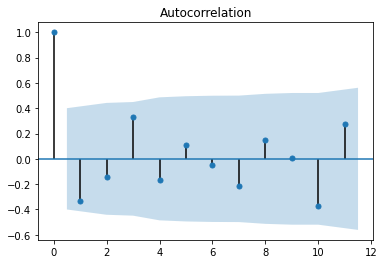

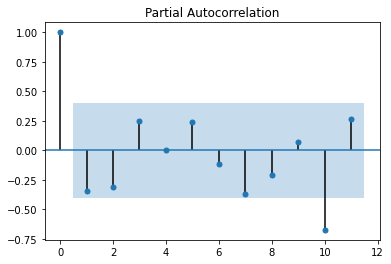

In [8]:
# Korelogram resid
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
print('Plot (P)ACF data residual regresi')
print('ACF -> MA')
a = plot_acf(resid, lags=11)
print('PACF -> AR')
b = plot_pacf(resid, lags=11)

Pilih kombinasi p dan q ARIMA yang terbaik 

In [100]:
# choose p,q from iteration combination
iterSeries = pd.Series()
for i in itertools.product([0,1,2], repeat=2):
    model = ARIMA(train.y, order=(i[0],0,i[1]), freq='MS',
                  exog = train.iloc[:,:koly2]).fit()
    #count
    varsig = model.pvalues[model.pvalues <= pval].index.values
    c = 0
    for a in varsig:
        for b in dfori.columns:
            if a==b: c+=1

    #logging
    print(f'p: {i[0]} | q: {i[1]} | \
sig: {len(varsig)} var | \
sig AIS: {c} | \
bic: {model.bic}')
    iterSeries = iterSeries.append( pd.Series(model.bic, index=[str(i[0])+','+str(i[1])]) )
    
print('ARMA:', iterSeries.idxmin(),'\nBIC:' ,iterSeries.min())

p: 0 | q: 0 | sig: 2 var | sig AIS: 1 | bic: 55.589246282764314
p: 0 | q: 1 | sig: 2 var | sig AIS: 1 | bic: 46.387584674193015
p: 0 | q: 2 | sig: 2 var | sig AIS: 1 | bic: 48.85942603705606
p: 1 | q: 0 | sig: 3 var | sig AIS: 1 | bic: 52.60343643434416
p: 1 | q: 1 | sig: 2 var | sig AIS: 1 | bic: 49.00282916624941
p: 1 | q: 2 | sig: 2 var | sig AIS: 1 | bic: 51.70152409534799
p: 2 | q: 0 | sig: 1 var | sig AIS: 0 | bic: 55.263076563150044
p: 2 | q: 1 | sig: 2 var | sig AIS: 1 | bic: 51.83509629688807
p: 2 | q: 2 | sig: 2 var | sig AIS: 1 | bic: 54.639394063338045
ARMA: 0,1 
BIC: 46.387584674193015


Pemodelan ARIMAX

In [28]:
#p AR; q MA
p = 2
q = 2
# MODELLING ARIMAX
#(endog, order, exog=None, dates=None, freq=None, missing='none')
model = ARIMA(train.y, order=(p,0,q),
              freq = 'MS', exog=train.iloc[:,:koly2])
# fit
model_fit = model.fit()
# summary
print(model_fit.summary())
# pred
pred_train = model_fit.predict(start = train.index[0], end = train.index[-1], 
                           exog=train.iloc[:,:koly]).values
y_pred = model_fit.predict(start = test.index[0], end = test.index[-1], 
                           #params=model_fit.params, 
                           exog=test.iloc[:,:koly2]).values

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   19
Model:                 ARIMA(2, 0, 2)   Log Likelihood                 -22.708
Date:                Tue, 06 Jul 2021   AIC                             65.417
Time:                        16:18:26   BIC                             74.861
Sample:                    01-01-2019   HQIC                            67.015
                         - 07-01-2020                                         
Covariance Type:                  opg                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -3.5620      2.993     -1.190      0.234      -9.428       2.304
numVisit_CT               0.8086      0.268      3.012      0.003       0.282       1.335
numVesse

Uji diagnostik model ARIMAX yang terbentuk

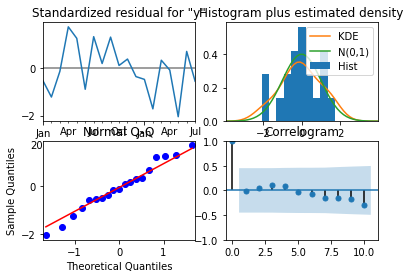

In [34]:
c = model_fit.plot_diagnostics()

## ANN rs

In [ ]:
i = 100
low = [1,1  ,0.00, 0.0, 0.0] 
up  = [4,100,4.99, 1.0, 1.0]
limit = False#1e-99

# run random search
gen,df_cost = optimize(function=ann_function, lower_boundary=low, upper_boundary= up,
                       limit = limit, 
                       x=x_train, y=y_train,                
                       max_iter=i, maximize=False) #karna mse maka minimize (mencari mse terkecil)
print(df_cost.tail())
# param terbaik (diconvert dari gen terbaik)
param = conv_param(gen)
# train model ann
w, pred_train, cost = ann_function(gen,x=x_train, y=y_train)
# prediksi x_test dg model ann
y_pred = np.squeeze(predict(x_test.values, w, param['activation']))
print('Pred test:',y_pred)

# Permutation importance
dict_param = {'weight':w, 'activation':param['activation']}
imp = permutation_importance(x_test, y_test, df2.columns[:-1], 
                             model=nn_model, dict_param=dict_param, n=50)
#imp = permutation_importance(x_train, y_train, df2.columns[:-1], model=gann)
# Nilai importance
#imp
df_cost.cost.plot(figsize=(10,3))

Indikator AIS yang memiliki importance value > 0

In [168]:
imp[imp.importance > 0].values

array([['numVisit_CT', 0.0027439999999999977],
       ['numVessel_CT', 0.055245999999999996],
       ['timeInPort_CT', 0.010310000000000003],
       ['numDraughtDiff_pos_CT', 0.0046840000000000015]], dtype=object)

# Eval peramalan

--Prediksi DATA TRAIN-----
RMSE: 0.41119503320314976
MAPE: 103.00367832542752
MAE: 0.31802925908760654
Korelasi: 0.915093924391458


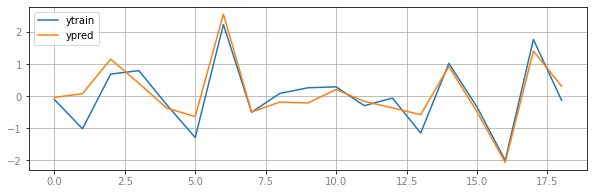

--Prediksi DATA TEST-----
RMSE: 1.0004328652483312
MAPE: 126.16734610233051
MAE: 0.7004973287166244
Korelasi: 0.4105769004300441
[ 0.5324  0.8756 -1.0661  1.2061 -1.1529]


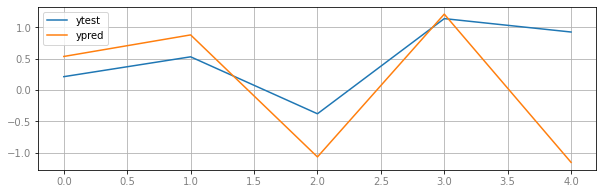

In [47]:
# DATA TRAIN
print('--Prediksi DATA TRAIN-----')
yptrain = np.squeeze(pred_train)#ann.predict(x_train)
yttrain = y_train.values
print('RMSE:', mean_squared_error(yttrain, yptrain, squared=False))
print('MAPE:', mape(yttrain, yptrain))
print('MAE:', mean_absolute_error(yttrain, yptrain))
print('Korelasi:', np.corrcoef(yttrain, yptrain)[1,0] )
plot([yttrain, yptrain], label=['ytrain','ypred'])

# DATA TEST
print('--Prediksi DATA TEST-----')
#yptest = np.squeeze(predict(x_test.values, w, param['activation']))
yptest = y_pred
yttest = y_test.values
print('RMSE:', mean_squared_error(yttest, yptest, squared=False))
print('MAPE:', mape(yttest, yptest))
print('MAE:', mean_absolute_error(yttest, yptest))
print('Korelasi:', np.corrcoef(yttest, yptest)[1,0] )
print(yptest)
plot([yttest, yptest], label=['ytest','ypred'])

# Convert awal
Konversi hasil peramalan ke sebelum transformasi data

19
['numVisit_CT', 'EksporVolume']
Asli: [55.1537 48.7145 57.5263 52.3653 57.68   46.4976 56.4081 52.3853 54.5882
 61.413  56.0222 55.7201 50.9254 49.6726 54.1281 45.1937 42.3176 46.4941
 46.3949]
Prediksi: [48.5844 47.9815 50.3866 49.7564 53.6559 48.0358 53.3825 53.5254 54.266
 56.5189 62.5929 60.3494 62.7305 63.8397 66.0354 60.6179 60.067  59.6075
 65.9212]
RMSE: 9.752687196667187
MAPE: 15.64707170670458
MAE: 7.730942909052172
Korelasi: -0.21269270392096462


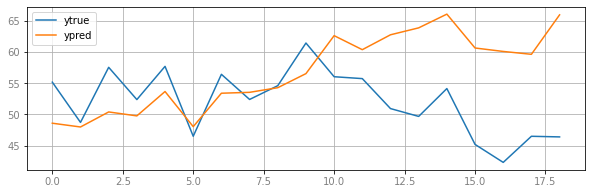

5
['numVisit_CT', 'EksporVolume']
Asli: [43.5797 43.9441 47.2177 53.2825 57.324 ]
Prediksi: [47.5719 45.504  49.5569 49.7797 47.5048]
RMSE: 5.148386844484486
MAPE: 8.273580851324116
MAE: 4.2426667217893215
Korelasi: 0.370908806675013


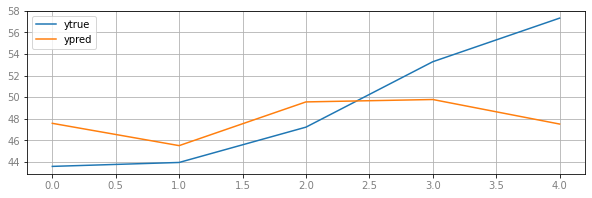

In [32]:
# convert ke awal
# train
asliTr,prediksiTr,\
nilaiRmseTr, nilaiMapeTr, dftr_pred = convert_awal(dfori, df2, x_train, x_test, y_train, y_test,
                            koly, koly2, lb, scaler,
                            y_pred=pred_train, pertumbuhan=pert)
# test
asliTs,prediksiTs,\
nilaiRmseTs, nilaiMapeTs, dfte_pred = convert_awal(dfori, df2, x_train, x_test, y_train, y_test,
                            koly, koly2, lb, scaler,
                            y_pred=y_pred, pertumbuhan=pert)

In [147]:
# var X dan Y yang digunakan
dfori.columns[koly2], var

('EksporVolume', 'AISc+None')

# Write the result
Summary result

## ARIMA

In [106]:
diag = reg.summary().tables[2].data
diag_reg = {'dw':diag[0][3].replace(' ',''), #dw
        'p_omnibus':diag[1][1].replace(' ',''), #p omnibus
        'p_jb':diag[2][3].replace(' ','')} #p jb
diag = model_fit.summary().tables[2].data
diag_model = {'p_ljungbox': diag[1][1],
              'p_jb':diag[1][3],
              'p_heteros':diag[3][1]}

result = pd.DataFrame([
    str(dfori.columns.values),
    str(reg.pvalues[reg.pvalues <= pval].index.values),
    diag_reg,
    (model_fit.model_orders['ar'],0,model_fit.model_orders['ma']),
    str(model_fit.pvalues[model_fit.pvalues <= pval].index.values),
    model_fit.aic,
    model_fit.bic,
    diag_model,
    mean_squared_error(yttrain, yptrain, squared=False),
    mape(yttrain, yptrain),
    mean_squared_error(yttest, yptest, squared=False),
    mape(yttest, yptest),
    str(prediksiTr.values), str(prediksiTs.values),
    nilaiRmseTr, nilaiMapeTr,
    nilaiRmseTs, nilaiMapeTs
], ['var', 'reg sig', 'reg diag', 'model',
    'model sig', 'model aic', 'model bic', 'model diag',
    'RMSE train', 'MAPE train',
    'RMSE test', 'MAPE test',
    'prediksi train true','prediksi test true',
    'RMSE train true', 'MAPE train true',
    'RMSE test true', 'MAPE test true',
   ])
print('Var:', str(var))
result.tail()

Var: AISr+None


,0
prediksi test true,[[12.548 ]\n [10.5349]\n [12.1794]\n [11.6885]...
RMSE train true,1.8576
MAPE train true,11.314
RMSE test true,2.4366
MAPE test true,12.0453


## ANN

In [148]:
result = pd.DataFrame([
    str(dfori.columns.values),
    str(gen),
    str(conv_param(gen)),
    str(imp[imp.importance > 0].values),
    mean_squared_error(yttrain, yptrain, squared=False),
    mape(yttrain, yptrain),
    mean_squared_error(yttest, yptest, squared=False),
    mape(yttest, yptest),
    str(prediksiTr.values), str(prediksiTs.values),
    nilaiRmseTr, nilaiMapeTr,
    nilaiRmseTs, nilaiMapeTs
], ['var','gen','param','importance',
    'RMSE train', 'MAPE train',
    'RMSE test', 'MAPE test',
    'prediksi train true','prediksi test true',
    'RMSE train true', 'MAPE train true',
    'RMSE test true', 'MAPE test true',
   ])
result.tail()

,0
prediksi test true,[[45.9059]\n [42.8261]\n [45.311 ]\n [45.0569]...
RMSE train true,14.9873
MAPE train true,27.7264
RMSE test true,7.2011
MAPE test true,10.1697


In [149]:
print('DF', dfori.columns[koly2])
print('VAR:', var)
df_cost['param'] = df_cost.gen.apply(conv_param)
df_cost.tail()

DF EksporVolume
VAR: AISc+None


,gen,cost,time,param
95,"[60.42898865369087, 8.813970116907214, 68.8366...",0.3418,30.7422,"{'hidden': [60, 9, 69], 'activation': 'leaky_r..."
96,"[60.42898865369087, 8.813970116907214, 68.8366...",0.3418,31.1382,"{'hidden': [60, 9, 69], 'activation': 'leaky_r..."
97,"[60.42898865369087, 8.813970116907214, 68.8366...",0.3418,31.5172,"{'hidden': [60, 9, 69], 'activation': 'leaky_r..."
98,"[60.42898865369087, 8.813970116907214, 68.8366...",0.3418,32.0398,"{'hidden': [60, 9, 69], 'activation': 'leaky_r..."
99,"[60.42898865369087, 8.813970116907214, 68.8366...",0.3418,32.5314,"{'hidden': [60, 9, 69], 'activation': 'leaky_r..."


# Check

In [34]:
param = {'hidden': [75, 50, 100], 'activation': 'leaky_relu', 'learning_rate': 0.7347716734280825, 'momentum': 0.5661957671681955}
param = {'hidden': [52, 24], 'activation': 'tanh', 'learning_rate': 0.21021661690615456, 'momentum': 0.4446454434393985}

param = {'hidden': [62, 88, 91], 'activation': 'leaky_relu', 'learning_rate': 0.9829296565588231, 'momentum': 0.5484032058260657}

In [35]:
param

{'hidden': [62, 88, 91],
 'activation': 'leaky_relu',
 'learning_rate': 0.9829,
 'momentum': 0.5484}

In [36]:
# param terbaik (diconvert dari gen terbaik)
#param = conv_param(gen)
# train model ann
w2, pred_train2, cost2 = ann_function(gen=False,x=x_train, y=y_train, param=param)
# prediksi x_test dg model ann
pred_train = np.squeeze(predict(x_train.values, w2, param['activation']))
y_pred = np.squeeze(predict(x_test.values, w2, param['activation']))
print(cost2)
print('Pred test:',y_pred)

0.3253686500225703
Pred test: [0.0409 0.2594 0.1402 0.0791 0.1536]


In [ ]:
# Nilai Prediksi
round(pd.Series(prediksi*1000),2)

In [ ]:
# Permutation importance
par_w_act = {'weight':w2, 'activation':param['activation']}
imp = permutation_importance(x_test, y_test, df2.columns[:-1], model=nn_model, dict_param=par_w_act, n=50)
#imp = permutation_importance(x_train, y_train, df2.columns[:-1], model=gann)
# nilai importance
#imp

# Read generated summary data

Kolom di summary data ARIMA n ANN

- Data ARIMA:
```
['var', 'reg sig', 'reg diag', 'model',
    'model sig', 'model aic', 'model bic', 'model diag',
    'RMSE train', 'MAPE train',
    'RMSE test', 'MAPE test',
    'prediksi train true','prediksi test true',
    'RMSE train true', 'MAPE train true',
    'RMSE test true', 'MAPE test true']
```
- Data ANN:
```
['var','gen','param','importance',
    'RMSE train', 'MAPE train',
    'RMSE test', 'MAPE test',
    'prediksi train true','prediksi test true',
    'RMSE train true', 'MAPE train true',
    'RMSE test true', 'MAPE test true']
```

In [7]:
data = 'EksporNilai'
#data = 'EksporVolume'
#data = 'ImporNilai'
#data = 'ImporVolume'

#var2 = ['RMSE train','RMSE test', 'RMSE train true','MAPE train true', 'RMSE test true','MAPE test true']
var2 = ['RMSE test','MAPE test']

kombs = ['AIS+None', 'AISf+None', 'AISs+None', 'AISc+None', 'AISr+None']

In [8]:
df_ann = read_result(data, 'ANN', kombs, var=var2+['param','var','prediksi test true','prediksi train true'])
for v in var2: df_ann[v] = [round(float(i),4) for i in df_ann[v]]
df_ann.iloc[:,:4]\
    .style.apply(highlight_min)

,RMSE test,MAPE test,param,var
ANN_EksporNilai,,,,
AIS+None,1.2118,320.6588,"{'hidden': [67, 48], 'activation': 'leaky_relu', 'learning_rate': 0.9467061893050145, 'momentum': 0.7707287674636406}",['numVisit_CT' 'numVessel_CT' 'timeInPort_CT' 'sumDraughtDiff_pos_CT' 'numDraughtDiff_pos_CT' 'EksporNilai']
AISf+None,0.9310,189.0330,"{'hidden': [48, 19, 76, 76], 'activation': 'relu', 'learning_rate': 0.6268495730790289, 'momentum': 0.5187068488323934}",['numVessel_CT' 'sumDraughtDiff_pos_CT' 'EksporNilai']
AISs+None,1.3935,329.9660,"{'hidden': [90, 15], 'activation': 'leaky_relu', 'learning_rate': 0.6876034414564896, 'momentum': 0.8665918633534219}",['numVisit_CT' 'numVessel_CT' 'timeInPort_CT' 'EksporNilai']
AISc+None,0.7950,192.1103,"{'hidden': [51], 'activation': 'leaky_relu', 'learning_rate': 0.7339481201925963, 'momentum': 0.8597094436673043}",['numVisit_CT' 'numVessel_CT' 'sumDraughtDiff_pos_CT' 'numDraughtDiff_pos_CT' 'EksporNilai']
AISr+None,0.7852,191.4499,"{'hidden': [75, 50, 100], 'activation': 'leaky_relu', 'learning_rate': 0.7347716734280825, 'momentum': 0.5661957671681955}",['numVisit_CT' 'EksporNilai']


In [9]:
df_arima = read_result(data, 'ARIMA', kombs, var=var2+['var','model sig','model','prediksi test true','prediksi train true'])
for v in var2: df_arima[v] = [round(float(i),4) for i in df_arima[v]]
df_arima.iloc[:,:4]\
    .style.apply(highlight_min)

,RMSE test,MAPE test,var,model sig
ARIMA_EksporNilai,,,,
AIS+None,1.6388,222.8764,['numVisit_CT' 'numVessel_CT' 'timeInPort_CT' 'sumDraughtDiff_pos_CT' 'numDraughtDiff_pos_CT' 'EksporNilai'],['numVisit_CT' 'numVessel_CT' 'timeInPort_CT' 'ar.L1' 'ar.L2']
AISf+None,1.4856,207.3801,['numVessel_CT' 'sumDraughtDiff_pos_CT' 'EksporNilai'],['numVessel_CT' 'sumDraughtDiff_pos_CT' 'ar.L7']
AISs+None,1.4063,261.3194,['numVisit_CT' 'numVessel_CT' 'timeInPort_CT' 'EksporNilai'],['const' 'numVisit_CT' 'numVessel_CT' 'timeInPort_CT']
AISc+None,1.8891,450.0597,['numVisit_CT' 'numVessel_CT' 'sumDraughtDiff_pos_CT' 'numDraughtDiff_pos_CT' 'EksporNilai'],['numVisit_CT' 'sumDraughtDiff_pos_CT' 'numDraughtDiff_pos_CT' 'ar.L1' 'ar.L8']
AISr+None,1.2496,234.0881,['numVisit_CT' 'EksporNilai'],['const' 'numVisit_CT' 'ar.L1' 'ar.L4' 'ar.L5' 'ar.L8']


## Coret 

In [241]:
dataname = '../AIS_UN/out_new.csv/out_dfx_newc.csv'
n = 19
d = pd.read_csv(dataname).set_index('period')\
    .iloc[n+1:,-4:]/1000000
    #.iloc[0+1:n+1,-4:]/1000000
d.index.name = 'periode'
d.head(2)

,EksporNilai,EksporVolume,ImporNilai,ImporVolume
periode,,,,
2020-08,13095.7810,43579.6685,10742.4078,11839.6908
2020-09,13960.5281,43944.1425,11570.1048,12883.2286


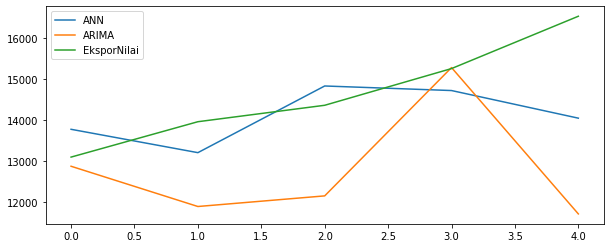

In [60]:
# SINGLE
# TEST
import json
ann = json.loads(df_ann['prediksi test true'][4].replace('\n',','))
arima = json.loads(df_arima['prediksi test true'][1].replace('\n',','))
pd.DataFrame([
    pd.Series(np.squeeze(ann)*1000),
    pd.Series(np.squeeze(arima)*1000),
    d[data].reset_index(drop=True),
], ['ANN','ARIMA',d[data].name]).T.plot(figsize=(10,4))

In [113]:
print(n,j)
dread
read_result(i, namamodel, [j], var=var2+[n])

param AISr+None


,RMSE train,RMSE test,RMSE train true,RMSE test true,param
ANN_EksporNilai,,,,,
AISr+None,0.7222745371524598,0.78519609807039,1.5996387758417954,1.2449274423960957,"{'hidden': [75, 50, 100], 'activation': 'leaky..."


In [287]:
import json
#print(data)
# MULTI
col = 0
for i,j in zip(['EksporNilai','EksporVolume','ImporNilai','ImporVolume'],
               ['AISr+None','AISs+None','AIS+None','AISf+None']):
               #['AISr+None','AISc+None','AISc+None','AISf+None']):
    namamodel = 'ANN' if col!=2 else 'ARIMA'
    dread = read_result(i, namamodel, [j], var=var2+['prediksi test true'])
    p = json.loads( dread['prediksi test true'][j]\
               .replace('\n',',') )
    p = np.squeeze(p)*1000
    d['Prediksi '+d.columns[col]] = p
    col += 1
#p
d
#df_ann['prediksi test true']['AIS+None']\
#    .replace('[','').replace(']','').split()

,EksporNilai,EksporVolume,ImporNilai,ImporVolume,Prediksi EksporNilai,Prediksi EksporVolume,Prediksi ImporNilai,Prediksi ImporVolume
periode,,,,,,,,
2020-08,13095.7810,43579.6685,10742.4078,11839.6908,13775.2,47571.9,11279.7,11384.4
2020-09,13960.5281,43944.1425,11570.1048,12883.2286,13204.4,45504.0,12777.2,11830.1
2020-10,14362.2426,47217.6795,10786.0167,12091.5465,14833.9,49556.9,10509.3,12075.2
2020-11,15259.3172,53282.4614,12664.4142,12137.1496,14722.4,49779.7,12459.4,12211.6
2020-12,16538.3107,57324.0164,14438.3761,15330.6694,14047.3,47504.8,10075.0,12489.9


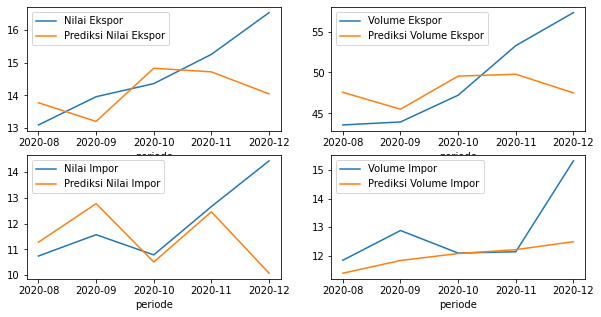

In [102]:
d = pd.read_csv('z_test.csv').set_index('periode')/1000
d.columns = l[:-4]
d.iloc[:,[0,4]]

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,5))
j = -1
for row in ax:
    for col in row:
        j+=1
    #for j in range(0,2):
        #col.plot(x, y)
        d.iloc[:,[j,j+4]].plot(ax=col)
        
#df1.plot(ax=ax[0,0])
#df2.plot(ax=ax[0,1])

plt.show()

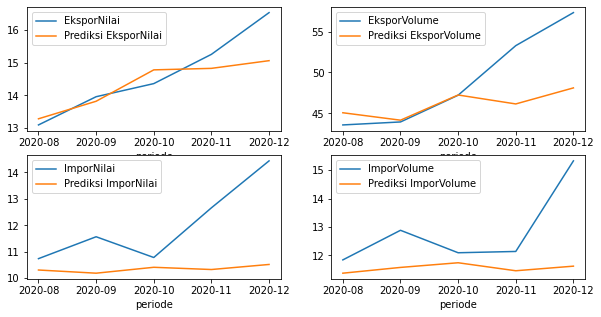

In [80]:
d = pd.read_csv('z_test_before.csv').set_index('periode')/1000
d.iloc[:,[0,4]]

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,5))
j = -1
for row in ax:
    for col in row:
        j+=1
    #for j in range(0,2):
        #col.plot(x, y)
        d.iloc[:,[j,j+4]].plot(ax=col)
        
#df1.plot(ax=ax[0,0])
#df2.plot(ax=ax[0,1])

plt.show()

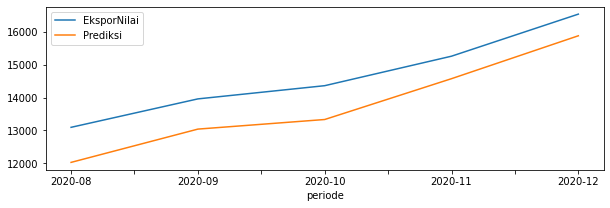

In [582]:
# SINGLE 2
dd = d[[data]]
dd['Prediksi'] = p
dd.plot(figsize = (10,3))

# Stepwise select

In [29]:
def stepwise_selection_bic(X, y, 
                       initial_list=[], 
                       threshold_in=0, 
                       threshold_out = 0, 
                       verbose=True):
    included = list(initial_list)
    model = sm.OLS(y, sm.add_constant(pd.DataFrame(X))).fit()
    best_bic_old = model.bic#100
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_bic = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_bic[new_column] = model.bic#[new_column]
        best_bic = new_bic.min()
        if ((best_bic_old - best_bic) > threshold_in):
            best_feature = new_bic.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:20} with bic improv {:.6}'.format(best_feature, (best_bic_old - best_bic)))
            best_bic_old = best_bic
            
        # backward step
        #if not changed : break
        #else: continue 
            
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        #pvalues = model.pvalues.iloc[1:]
        bic_old = model.bic
        new_bic = pd.Series(bic_old, index=included)
        for column in included:
            removed = list(set(included)-set([column]))
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[removed]))).fit()
            new_bic[column] = model.bic
        worst_bic = new_bic.max() # null if pvalues is empty
        #print(new_bic, bic_old)
        if ((bic_old - worst_bic) > threshold_out):
            changed=True
            worst_feature = new_bic.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:20} with bic improv {:.6}'.format(worst_feature, (bic_old - worst_bic)))
        if not changed:
            break
    return included

In [30]:
# Stepwise select based on bic
result = stepwise_selection_bic(df2.iloc[:,:koly2], df2.iloc[:,koly2],
                           threshold_in = -0.5, threshold_out = 5)

Add  numVisit_CT          with bic improv 9.56211


In [15]:
result

['numVisit_CT']